<a href="https://colab.research.google.com/github/selenajoetwilliams/fer_image_classifier/blob/main/simple_facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition Model

This is a simple CNN architecture for facial expression recognition using the FER 2013 Dataset

Thank you to Ifrah Idrees & the Brown University Humans to Robots lab for your mentoring and support in this project!

**Note:** I followed [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) image classification tutorial on pytorch documentation which I have adapted from image classification to facial epxression recognition.

# 0. Imports

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Load & process data

# loading the dataset

First we transform the data to fit a standardized format.

Then we define batch_size, dataset, validation_set, and the classes, which are our labels for facial expression classification

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

# batch sizes of 32, 64, or 128 are commonly used in many deep learning applications, but we start w/ batch_size = 4 as a simple starting point
batch_size = 4

dataset = torchvision.datasets.FER2013(root='/content/drive/MyDrive/', split="train", transform=transform) 

# NOTE: we probably won't use the validation set -- since it doesn't have ground truth labels
validation_set = torchvision.datasets.FER2013(root='/content/drive/MyDrive', split="test", transform=transform)

classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')



# Splitting the data 80-20 
80% for training, 20% for testing 

**Note:** Since the validation_set doesn't have any ground_truth labels, we split the training data 80-20 to train the model and test it's accuracy against ground truth labels 

In [ ]:
# calculating how many samples should be in the train & test sets based on an 80-20 split
data_size = len(dataset) 
num_training_samples = round(data_size * 0.8, 0) # the 0 parameter specifies that we want to round to the 0th digit so that we are left with whole #s (no decimals)
num_testing_samples = round(data_size * 0.2, 0)

# initialize empty lists to hold the training & testing data
# note that data were shuffled when loaded so no randomizing has already occured 
train_set = []
test_set = []

# populating the train_set & test_set for an 80-20 split
for x, batch in enumerate(dataset): # use the enumerate function to iterate over the dataset
    # populating train_set
    if x < num_training_samples:
        train_set.append(batch)
    # populating test_set
    if x >= num_training_samples:
        test_set.append(batch)
  
# printing out info about the dataset
print('The dataset has ' + int(data_size) + ' elements') # dataset size
print('The dataset source is ' + type(dataset))
# calculating # of samples for 80-20 split
print("data size is: " + str(data_size) + " so there are " + str(num_training_samples) + " training samples and " + str(num_testing_samples) + " testing samples.") 

# printing length of train_set & test_set to make sure that it was split 80-20
print("the test set has " + str(len(test_set)) + " samples.")
print("the train set has " + str(len(train_set)) + " samples.")


28709
<class 'torchvision.datasets.fer2013.FER2013'>
data size is: 28709 so there are 22967.0 training samples and 5742.0 testing samples.
the test set has 5742 samples.
the train set has 22967 samples.


# loading the train_set and test_set
Using pytorch Dataloader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2) 

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Visualizing Data

First, define imshow, a common function to display images using matplotlib & numpy

**Note:** the range here used to be batch_size, but was changed to 4 to prevent display bugs if the batch_size is increased to 32 or 64 later

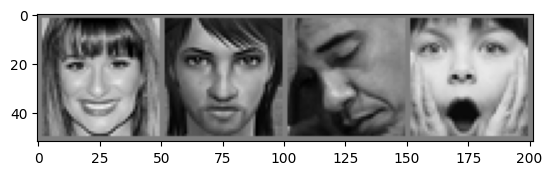

Happy Neutral Sad   Surprise


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels using f string concatenation
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# 2. Defining a Convolutional Neural Network
Here we define a very basic CNN structure with 2 convolutional layers & 3 fully connected layers. We also define the forward pass which is common practice.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        print("in this forward pass, x is ")
        print(x)


net = Net() # this creates an instance of the Net class, which has the constructor & forward function defined above


# 3. Define the Loss Function & optimizer
Here we use Classification Cross-Entropy loss & SGD (stochastic gradient descent) with momentum

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network
To do this we simply loop over the data iterator and feed the data into the network & optimize

**Note** that we only have 2 epochs -- this is a sign of a really simple model. Increasing the epochs will increase model accuracy.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    print('epoch ' + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        '''
        the 4 lines below represent one iteration through the training data

        about the bottom 2 lines: 
        Together, these two lines of code represent one iteration of the training process. 
        The loss is computed for the current batch of data, the gradients are calculated, 
        and the optimizer updates the model parameters accordingly. This process is repeated 
        for multiple iterations (or "epochs") until the model's performance on a validation 
        set reaches a satisfactory level.
        '''

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # criterion is just a fancy word for the loss function!
        loss.backward() 
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

epoch 0
[1,  2000] loss: 1.810
[1,  4000] loss: 1.707
epoch 1
[2,  2000] loss: 1.587
[2,  4000] loss: 1.530
Finished Training


# Saving the model
Let's quickly save our trained model:
**Note: ** this isn't necessary but it's helpful to have an example of how to save it here, and provides an option for people to save the model if they clone this

In [ ]:
PATH = './fer2013_net.pth' # Note that this name should change when we adapt this to fer dataset
torch.save(net.state_dict(), PATH)

Next, let's load back in our saved model

# Loading the model

**Note:** As mentioned, saving and re-loding the model ins't necesary here -- we only did it to illustrate how to do so  :)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 5. Visualizing the test data

Before we check the accuracy of the model, let's visualize the test data to make sure it's what we expect.

Examples of test images


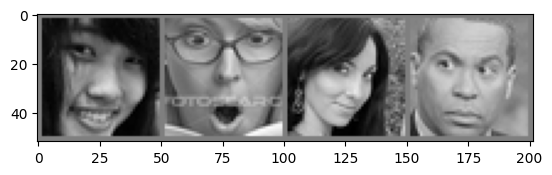

Happy Surprise Happy Angry


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
print("Examples of test images")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Running the model on 4 test images

Now that we can see the 4 test images & their labels, let's see what the neural network thinks the 4 examples above are.

**Note:** This is a good practice to gauge how the model is doing before running it on the whole dataset

In [1]:
outputs = net(images)
print(outputs) # this isn't necessary

NameError: ignored

The outputs are energies for the 7 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [ ]:
# torch.max returns [maximum_tensor_value, index of the class with the highest probability]
# prediced is a list of the indices of the labels
_, predicted = torch.max(outputs, 1) # interestingly, '_,' is used to discard the first thing that torch.max returns

# the label index is passed into the classes list to return the string representing the class label (at the predicted index)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

# this is unecessary, but helps to understand what each variable is
print("The corresponding class labels for the predictions are " + str(predicted) + " from the following classes: \n" + str(classes))


Predicted:  Happy Fear  Sad   Neutral
The corresponding class labels for the predictions are tensor([3, 2, 4, 6]) from the following classes: 
('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')


# Running the model on the entire test dataset
Now we will run the model on the whole test dataset to see how it performs. Notice that we use simple counters to track & compute the average accuracy

**Note:** we use torch.no_grad() when we're not training the model,because we don't need to compute gradients during the testing phase & it would just waste space in memory

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) # (outputs, 1) returns the class predictions like [3, 1, 8, 0] above
        # collct the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 44 %


That is better than chance, which is 14% accuracy (picking a class at random), which means that the model has learned something.

Now let's see which classes that performed well and which didn't.

# Exploring which classes performed well & which didn't

Note: Notice that you will get different accuracies for each class every time you train the neural network. This is partly due to random initialization of weights & biases and shuffling of training data (i.e. when shuffle=True in the dataloader)

In [ ]:
correct_pred = {classname: 0 for classname in classes} # using dictionary comprehension here
total_pred = {classname: 0 for classname in classes} 

array = [0] * 7 # create an array w/ 7 slots

# again, no gradients are needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions): # for each label

            array[label] += 1 #TODO: DO I NEED THIS LINE?? 

            if label == prediction: # if the (actual) label = the (expected) prediction 
                correct_pred[classes[label]] += 1 # increment correct predictions counter
            total_pred[classes[label]] += 1 # increment total predictions 

print(array)
print(total_pred)
print('label is ' + str(label))
print(total_pred[classes[label]])


i = 0 
for classname, correct_count in correct_pred.items():
    print(classname)
    accuracy = 100 * float(correct_count) / total_pred[classname]
    # print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} % out of {array[i]} samples in that class')
    i += 1



[805, 74, 779, 1445, 971, 684, 984]
{'Angry': 805, 'Disgust': 74, 'Fear': 779, 'Happy': 1445, 'Sad': 971, 'Surprise': 684, 'Neutral': 984}
label is tensor(4)
971
Angry
Accuracy for class: Angry is 15.9 % out of 805 samples in that class
Disgust
Accuracy for class: Disgust is 0.0 % out of 74 samples in that class
Fear
Accuracy for class: Fear  is 25.4 % out of 779 samples in that class
Happy
Accuracy for class: Happy is 72.7 % out of 1445 samples in that class
Sad
Accuracy for class: Sad   is 46.7 % out of 971 samples in that class
Surprise
Accuracy for class: Surprise is 55.7 % out of 684 samples in that class
Neutral
Accuracy for class: Neutral is 33.4 % out of 984 samples in that class


# Running the neural net on the GPU

This is optional, but running on GPU is much faster than CPU

# Training on GPU 
## using "if torch.cuda.is_available"
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU. 
Let's first deine our device as the first visible cuda device is we have CUDA available:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
# Now print device to see if we are running on the GPU (cuda) or CPU
print(device) 

cuda:0


### **Note:** the rest of this sections assumes that device is a CUDA device

Theses methods will recursively go ove all modules and convert their parameters and buffers to CUDA tensors:


### **Note:** When running on Google Colab, if you get an **error related to 'no NVIDIA driver'** it just means you need to **change runtime type** from CPU -> GPU by clicking Runtime > Change Runtime Type above. Google Collab runs code remotely on google servers and gives you the choice between running on CPU or GPU.


In [ ]:
net.to(device)

RuntimeError: ignored

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

Currently there isn't a massive speedup compared to CPU because the network is really small (basic architecture, very few epochs). 

Increasing the width of the network (argument 2 of the first nn.Conv2d & argument 1 of the second nn.Conv2d -- they need to be the same number), will yield more significant GPU speed ups than the current architecture. 

# Learning Outcomes:

*   Understanding PyTorches Tensor librrary and neural networks at a high level
*   Train a small neural network to classify emotions using FER2013 dataset
*   Split training data & testing data
*   Familiarity with numpy & matplotlib
*   Familiarity with tensor transforms to normalize & pre-process images
*   Familiarity with pytorch dataloader, enumerate, and other essential ML functions in pytorch
*   Understanding f-string concatenation
*   Practice adapting documentation & best-practices to common datasets & CV tasks
